# Accompl-It 
ACCEPT Regression Subtask: providing an acceptability score on a 1-7 Likert scale for each sentence in the test set, along with an estimation of its standard error;

#### Import

In [2]:
#importo i pacchetti necessari (espressioni regolari, spostamenti tra le cartelle, pandas)
import re 
import os 
import pandas as pd
import numpy as np

In [3]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.feature_extraction import DictVectorizer

In [4]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

# Task 1: Regressione con Profiling UD #

Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione
del testo basata solo su informazioni linguistiche non lessicali estratte utilizzando il sistema
Profiling-UD. Riportare i seguenti risultati:
- valutazione del sistema con un processo di 5-fold cross validation condotto sul training
set;
- valutazione del sistema sul test set ufficiale del task;


### Preparazione dati per Universal Dependencies

In [6]:
#definisco i path per i dati di train e test
train_path = 'data/Evalita-2020-accomplit/AcCompl-it_training/ACCEPT-Corpus-training.tsv'
test_path = 'data/Evalita-2020-accomplit/AcCompl-it_test/acceptability-set-test.tsv'
#definisco il path per la cartella in cui andranno inseriti i file a cui applicare profiling UD
prof_input= 'data/profiling_input'

In [7]:
#visualizzo i primi 5 record del dataset di train
df = pd.read_csv(train_path, sep='\t')
df.head()

,id,N,mean,sd,se,sentence,task,reference
0,AC-01-R0001,14,5.285714,1.325987,0.354385,Quando gli invitati erano in ritardo lui avver...,acceptability,mancini_etal_2018
1,AC-01-R0002,10,6.700000,0.674949,0.213437,I ciclisti hanno pedalato.,acceptability,greco_etal_2020
2,AC-01-R0003,10,6.800000,0.632456,0.200000,I malati hanno starnutito.,acceptability,greco_etal_2020
3,AC-01-R0004,11,6.272727,1.489356,0.449058,Secondo te i maiali sono ingrassati?,acceptability,greco_etal_2020
4,AC-01-R0005,30,5.466667,1.696514,0.309740,Sono gli architetti che voi ingegneri avete co...,acceptability,chesi_canal_2019


In [8]:
train_punti = dict()

for line in open(train_path, 'r'):
    splitted_line = line.strip().split('\t')
    if splitted_line[0] != 'id':
       #per ciascuno ricavo le informazioni principali (id, frase, punteggio)
        sent_id = splitted_line[0]
        sentence = splitted_line[5]
        score = splitted_line[2]

        #creo un file txt per ogni record dentro la cartella profiling input 
        #ogni file si chiama con l'id e contiene la frase corrispondente al record  
        
        out_path = os.path.join(prof_input, f'{sent_id}.txt') 
        with open(out_path, 'w+') as out_file:
            out_file.write(sentence)
        
        #inserisco nel dizionario il record in forma id : "punteggio"
        train_punti[sent_id] = score
        

In [9]:
#controllo la lunghezza del dizionario = numero di elementi nel training set
len(train_punti)

1339

In [10]:
#creo un dizionario per le labels del test
test_punti = dict()

#scorro tutti gli elementi del test set
for line in open(test_path, 'r'):    
    splitted_line = line.strip().split('\t')
    if splitted_line[0] != 'id':
        #per ciascuno ricavo le informazioni principali (id, frase, punteggio)
        sent_id = splitted_line[0]
        sentence = splitted_line[5]
        score = splitted_line[2]
        #creo un file txt per ogni record dentro la cartella profiling input che avevo creato
        #ogni file si chiama con l'id e contiene la frase corrispondente al record   
        #inserirò questa catella zippata come input di profiling UD
        
        out_path = os.path.join(prof_input, f'{sent_id}.txt')
        with open(out_path, 'w+') as out_file:
            out_file.write(sentence)
        
        #inserisco nel dizionario il record in forma id : "punteggio"
        test_punti[sent_id] = score

In [11]:
len(test_punti)

344

In [12]:
#definisco il path del file in cui inserirò i punteggi
punteggi_path = 'data/punteggi.tsv'

In [13]:
#apriamo il file in scrittura e ci inseriamo per ogni record una riga con id, punteggio, train/test
with open(punteggi_path, 'w+') as out_file:
    for sent_id in train_punti:
        out_file.write('\t'.join([sent_id, train_punti[sent_id], 'train'])+'\n')
    for sent_id in test_punti:
        out_file.write('\t'.join([sent_id, test_punti[sent_id], 'test'])+'\n')

In [14]:
#funzione di caricamento dei punteggi in un dizionario id:score (con score come float e non come stringa)
def load_punteggi(punteggi_path):
    train_scores_dict = dict()
    test_scores_dict = dict()
    
    for line in open(punteggi_path, 'r'):
        line = line.strip().split('\t')
        sent_id = line[0]
        score = float(line[1])
        split = line[2]
        
        if split == 'train':
            train_scores_dict[sent_id] = score
        else:
            test_scores_dict[sent_id] = score
    
    return train_scores_dict, test_scores_dict
    

In [15]:

#creo due dizionari con id:scores per test e train set
train_scores_dict, test_scores_dict = load_punteggi(punteggi_path)


In [16]:
train_scores_dict

{'AC-01-R0001': 5.285714286,
 'AC-01-R0002': 6.7,
 'AC-01-R0003': 6.8,
 'AC-01-R0004': 6.272727273,
 'AC-01-R0005': 5.466666667,
 'AC-01-R0006': 6.1,
 'AC-01-R0007': 6.214285714,
 'AC-01-R0008': 5.882352941,
 'AC-01-R0009': 1.388888889,
 'AC-01-R0010': 5.411764706,
 'AC-01-R0011': 1.857142857,
 'AC-01-R0012': 6.363636364,
 'AC-01-R0013': 6.6,
 'AC-01-R0014': 5.3,
 'AC-01-R0015': 5.705882353,
 'AC-01-R0016': 6.1875,
 'AC-01-R0017': 1.857142857,
 'AC-01-R0018': 6.352941176,
 'AC-01-R0019': 5.1,
 'AC-01-R0020': 6.529411765,
 'AC-01-R0021': 7.0,
 'AC-01-R0022': 5.117647059,
 'AC-01-R0023': 3.411764706,
 'AC-01-R0024': 6.583333333,
 'AC-01-R0025': 1.944444444,
 'AC-01-R0026': 5.8125,
 'AC-01-R0027': 3.875,
 'AC-01-R0028': 4.2,
 'AC-01-R0029': 5.25,
 'AC-01-R0030': 3.176470588,
 'AC-01-R0031': 6.117647059,
 'AC-01-R0032': 4.5,
 'AC-01-R0033': 6.375,
 'AC-01-R0034': 6.357142857,
 'AC-01-R0035': 2.3,
 'AC-01-R0036': 5.785714286,
 'AC-01-R0037': 2.083333333,
 'AC-01-R0038': 4.4,
 'AC-01-R0039':

### Estrazione dei dati e divisione train/test

In [17]:
#definisco il path del file csv con gli output di profiling UD
profiling_output_path = 'data/profiling_output/6902.csv'

In [18]:
#visualizzo il file con pandas
df = pd.read_csv(profiling_output_path, sep='\t')
df.head()

,Filename,n_sentences,n_tokens,tokens_per_sent,char_per_tok,upos_dist_ADJ,upos_dist_ADP,upos_dist_ADV,upos_dist_AUX,upos_dist_CCONJ,...,dep_dist_root,dep_dist_xcomp,principal_proposition_dist,subordinate_proposition_dist,subordinate_post,subordinate_pre,avg_subordinate_chain_len,subordinate_dist_1,subordinate_dist_2,subordinate_dist_3
0,profiling_input/AC-OC-02-R0543.conllu,1,9,9.0,5.125000,0.0,0.000000,0.0,11.111111,11.111111,...,11.111111,0.0,50.0,50.0,100.0,0.0,1.0,100.0,0.0,0.0
1,profiling_input/AC-01-R0344.conllu,1,14,14.0,4.846154,0.0,21.428571,0.0,7.142857,0.000000,...,7.142857,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,profiling_input/AC-01-R0902.conllu,1,7,7.0,4.833333,0.0,14.285714,0.0,14.285714,0.000000,...,14.285714,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,profiling_input/AC-01-R0794.conllu,1,11,11.0,4.200000,0.0,9.090909,0.0,9.090909,0.000000,...,9.090909,0.0,50.0,50.0,100.0,0.0,1.0,100.0,0.0,0.0
4,profiling_input/AC-01-R0655.conllu,1,12,12.0,3.272727,0.0,16.666667,0.0,8.333333,0.000000,...,8.333333,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
def load_dataset(src_path):
    #creo una lista vuota dataset in cui inserisco le informazioni del file csv
    dataset = []
    for line in open(src_path, 'r'):
        splitted_line = line.strip().split('\t')
        #con la prima riga creo una lista con tutti i nomi delle features    
        if splitted_line[0] == 'Filename':
            features_names = splitted_line[1:] 
        else: #con le successive creo una lista in cui ogni riga è una lista con id e valori delle features dell'elemento 
            dataset.append(splitted_line) 
    return dataset, features_names

In [20]:
dataset, features_names = load_dataset(profiling_output_path)

In [21]:
print(f'Numero features: {len(features_names)}')
print('Lista features:')
#stampo la lista delle features
print(features_names)

Numero features: 115
Lista features:
['n_sentences', 'n_tokens', 'tokens_per_sent', 'char_per_tok', 'upos_dist_ADJ', 'upos_dist_ADP', 'upos_dist_ADV', 'upos_dist_AUX', 'upos_dist_CCONJ', 'upos_dist_DET', 'upos_dist_NOUN', 'upos_dist_NUM', 'upos_dist_PRON', 'upos_dist_PROPN', 'upos_dist_PUNCT', 'upos_dist_SCONJ', 'upos_dist_VERB', 'lexical_density', 'verbs_tense_dist_Fut', 'verbs_tense_dist_Imp', 'verbs_tense_dist_Past', 'verbs_tense_dist_Pres', 'verbs_mood_dist_Cnd', 'verbs_mood_dist_Imp', 'verbs_mood_dist_Ind', 'verbs_mood_dist_Sub', 'verbs_form_dist_Fin', 'verbs_form_dist_Ger', 'verbs_form_dist_Inf', 'verbs_form_dist_Part', 'verbs_num_pers_dist_Plur+1', 'verbs_num_pers_dist_Plur+2', 'verbs_num_pers_dist_Plur+3', 'verbs_num_pers_dist_Sing+1', 'verbs_num_pers_dist_Sing+2', 'verbs_num_pers_dist_Sing+3', 'aux_tense_dist_Imp', 'aux_tense_dist_Past', 'aux_tense_dist_Pres', 'aux_mood_dist_Cnd', 'aux_mood_dist_Ind', 'aux_mood_dist_Sub', 'aux_form_dist_Fin', 'aux_form_dist_Inf', 'aux_form_dis

In [22]:
# stampo il primo elemento della lista dataset
print('Primo elemento del dataset:')
print(dataset[0])

Primo elemento del dataset:
['profiling_input/AC-OC-02-R0543.conllu', '1', '9', '9.0', '5.125', '0', '0', '0', '11.11111111111111', '11.11111111111111', '0', '0', '0', '0', '22.22222222222222', '11.11111111111111', '11.11111111111111', '33.333333333333336', '0.625', '0', '33.333333333333336', '66.66666666666667', '0', '0', '0', '100.0', '0', '33.333333333333336', '0', '0', '66.66666666666667', '0', '0', '0', '100.0', '0', '0', '100.0', '0', '0', '0', '100.0', '0', '100.0', '0', '0', '0', '0', '0', '0', '100.0', '3.0', '100.0', '2.0', '0', '33.333333333333336', '33.333333333333336', '33.333333333333336', '0', '0', '0', '3.0', '3.0', '4.0', '2.2857142857142856', '4', '0', '0', '0', '0', '0', '0', '100.0', '0.0', '0', '0', '0', '0', '0', '0', '11.11111111111111', '0', '0', '11.11111111111111', '11.11111111111111', '0', '11.11111111111111', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '11.11111111111111', '0', '22.22222222222222', '0', '0', '0', '0', '0', '11.11111111111111', '11.1111

In [23]:
#modifico l'id degli elementi del dataset perchè corrisponda con le liste precedenti
for el in dataset:
    splitto = el[0].split('/')
    splitto2 = splitto[1].split('.')
    el[0] = splitto2[0]

In [24]:
print(dataset[0])

['AC-OC-02-R0543', '1', '9', '9.0', '5.125', '0', '0', '0', '11.11111111111111', '11.11111111111111', '0', '0', '0', '0', '22.22222222222222', '11.11111111111111', '11.11111111111111', '33.333333333333336', '0.625', '0', '33.333333333333336', '66.66666666666667', '0', '0', '0', '100.0', '0', '33.333333333333336', '0', '0', '66.66666666666667', '0', '0', '0', '100.0', '0', '0', '100.0', '0', '0', '0', '100.0', '0', '100.0', '0', '0', '0', '0', '0', '0', '100.0', '3.0', '100.0', '2.0', '0', '33.333333333333336', '33.333333333333336', '33.333333333333336', '0', '0', '0', '3.0', '3.0', '4.0', '2.2857142857142856', '4', '0', '0', '0', '0', '0', '0', '100.0', '0.0', '0', '0', '0', '0', '0', '0', '11.11111111111111', '0', '0', '11.11111111111111', '11.11111111111111', '0', '11.11111111111111', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '11.11111111111111', '0', '22.22222222222222', '0', '0', '0', '0', '0', '11.11111111111111', '11.11111111111111', '0', '50.0', '50.0', '100.0', '0.0', '

In [25]:
train_punti.keys()

dict_keys(['AC-01-R0001', 'AC-01-R0002', 'AC-01-R0003', 'AC-01-R0004', 'AC-01-R0005', 'AC-01-R0006', 'AC-01-R0007', 'AC-01-R0008', 'AC-01-R0009', 'AC-01-R0010', 'AC-01-R0011', 'AC-01-R0012', 'AC-01-R0013', 'AC-01-R0014', 'AC-01-R0015', 'AC-01-R0016', 'AC-01-R0017', 'AC-01-R0018', 'AC-01-R0019', 'AC-01-R0020', 'AC-01-R0021', 'AC-01-R0022', 'AC-01-R0023', 'AC-01-R0024', 'AC-01-R0025', 'AC-01-R0026', 'AC-01-R0027', 'AC-01-R0028', 'AC-01-R0029', 'AC-01-R0030', 'AC-01-R0031', 'AC-01-R0032', 'AC-01-R0033', 'AC-01-R0034', 'AC-01-R0035', 'AC-01-R0036', 'AC-01-R0037', 'AC-01-R0038', 'AC-01-R0039', 'AC-01-R0040', 'AC-01-R0041', 'AC-01-R0042', 'AC-01-R0043', 'AC-01-R0044', 'AC-01-R0045', 'AC-01-R0046', 'AC-01-R0047', 'AC-01-R0048', 'AC-01-R0049', 'AC-01-R0050', 'AC-01-R0051', 'AC-01-R0052', 'AC-01-R0053', 'AC-01-R0054', 'AC-01-R0055', 'AC-01-R0056', 'AC-01-R0057', 'AC-01-R0058', 'AC-01-R0059', 'AC-01-R0060', 'AC-01-R0061', 'AC-01-R0062', 'AC-01-R0063', 'AC-01-R0064', 'AC-01-R0065', 'AC-01-R0066',

In [26]:
dataset[0][0]

'AC-OC-02-R0543'

In [27]:
#qui splitto gli elementi del dataset in train e test 
def split_train_test(dataset):
    train_dataset = []
    test_dataset = [] 
    for user_list in dataset:
        file_name = user_list[0]
        if file_name in train_punti.keys(): #controllo se il nome del file fa parte della lista iniziale di elementi del train
            train_dataset.append(user_list)
        else:
            test_dataset.append(user_list)
    return train_dataset, test_dataset

In [28]:
train_dataset, test_dataset = split_train_test(dataset)

print('User training set:', len(train_dataset))
print('User test set:', len(test_dataset))

User training set: 1339
User test set: 344


In [29]:
train_dataset

[['AC-01-R0344',
  '1',
  '14',
  '14.0',
  '4.846153846153846',
  '0',
  '21.428571428571427',
  '0',
  '7.142857142857143',
  '0',
  '28.571428571428573',
  '28.571428571428573',
  '0',
  '7.142857142857143',
  '0',
  '7.142857142857143',
  '0',
  '0',
  '0.3076923076923077',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '100.0',
  '0',
  '100.0',
  '0',
  '100.0',
  '0',
  '0',
  '0',
  '0',
  '100.0',
  '0',
  '0',
  '1.0',
  '100.0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '3.0',
  '14.0',
  '8.0',
  '2.5833333333333335',
  '8',
  '1.0',
  '2',
  '100.0',
  '0',
  '0',
  '0',
  '100.0',
  '0.0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '21.428571428571427',
  '0',
  '0',
  '0',
  '0',
  '7.142857142857143',
  '0',
  '28.571428571428573',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '14.285714285714286',
  '7.142857142857143',
  '0',
  '0',

In [30]:
y_train = []
for el in train_dataset:
    el_id = el[0]
    y_train.append(train_scores_dict[el_id])

y_test = []
for el in test_dataset:
    el_id = el[0]
    y_test.append(test_scores_dict[el_id])

In [31]:
len(y_train), len(y_test)

(1339, 344)

In [32]:
#tolgo il nome del file perchè non serve più (e perchè poi non posso normalizzarlo perchè non è un numero)
for doc in train_dataset:
    doc.pop(0)

for doc in test_dataset:
    doc.pop(0)

In [33]:
#lunghezza degli elementi del dataset uguale a numero features
print(len(train_dataset[1]))
print(len(test_dataset[1]))

115
115


### Normalizzazione

In [34]:
X_train = train_dataset
X_test = test_dataset

In [35]:
# standardizzo i nuovi training e test set
sclr = MinMaxScaler() 
X_train = sclr.fit_transform(X_train)
X_test = sclr.transform(X_test)

In [36]:
X_train

array([[0.    , 0.5625, 0.5625, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.375 , 0.375 , ..., 1.    , 0.    , 0.    ],
       [0.    , 0.4375, 0.4375, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.6875, 0.6875, ..., 1.    , 0.    , 0.    ],
       [0.    , 0.3125, 0.3125, ..., 1.    , 0.    , 0.    ],
       [0.    , 0.5   , 0.5   , ..., 1.    , 0.    , 0.    ]])

In [37]:
#punteggi corretti del test
train_scores_dict.values()

dict_values([5.285714286, 6.7, 6.8, 6.272727273, 5.466666667, 6.1, 6.214285714, 5.882352941, 1.388888889, 5.411764706, 1.857142857, 6.363636364, 6.6, 5.3, 5.705882353, 6.1875, 1.857142857, 6.352941176, 5.1, 6.529411765, 7.0, 5.117647059, 3.411764706, 6.583333333, 1.944444444, 5.8125, 3.875, 4.2, 5.25, 3.176470588, 6.117647059, 4.5, 6.375, 6.357142857, 2.3, 5.785714286, 2.083333333, 4.4, 1.416666667, 6.882352941, 6.75, 5.6875, 5.785714286, 5.3, 1.722222222, 2.823529412, 1.666666667, 1.583333333, 5.941176471, 5.333333333, 5.294117647, 5.5, 4.988235294, 4.576470588, 6.1, 4.8125, 4.7, 2.214285714, 6.411764706, 4.363636364, 1.857142857, 6.714285714, 5.8125, 4.505882353, 2.976470588, 6.0, 6.727272727, 5.833333333, 6.0, 6.545454545, 5.944444444, 1.75, 3.764705882, 6.8, 1.5, 5.433333333, 1.785714286, 1.5, 4.5, 5.1, 3.909090909, 6.0625, 4.9375, 1.5, 1.722222222, 5.125, 5.9, 5.833333333, 5.722222222, 6.666666667, 6.25, 4.352941176, 6.7, 6.5, 5.5, 6.666666667, 5.176470588, 4.1, 7.0, 6.111111111, 

In [38]:
# creo le liste con i punteggi gold di train e test
#  y_train = list(train_scores_dict.values())
# y_test = list(test_scores_dict.values())

In [39]:
y_train

[6.5,
 2.047058824,
 6.181818182,
 2.466666667,
 6.5,
 6.7,
 4.576470588,
 3.8,
 3.8,
 5.363636364,
 4.538461538,
 6.166666667,
 2.533333333,
 4.277777778,
 4.423529412,
 4.8,
 6.272727273,
 2.846153846,
 5.0,
 2.857142857,
 5.9,
 5.833333333,
 5.25,
 3.214285714,
 5.166666667,
 1.333333333,
 4.470588235,
 6.25,
 4.529411765,
 1.583333333,
 6.0,
 3.769230769,
 3.4,
 3.6875,
 5.928571429,
 5.529411765,
 1.916666667,
 1.714285714,
 3.9,
 6.333333333,
 6.2,
 4.078947368,
 2.5,
 5.125,
 6.363636364,
 6.625,
 6.545454545,
 2.153846154,
 5.833333333,
 2.6,
 2.285714286,
 6.133333333,
 4.647058824,
 6.214285714,
 6.266666667,
 6.7,
 4.5625,
 3.142857143,
 6.333333333,
 3.411764706,
 1.642857143,
 3.428571429,
 1.714285714,
 2.866666667,
 5.4,
 3.0,
 6.7,
 3.384615385,
 6.722222222,
 6.375,
 6.333333333,
 6.5,
 6.909090909,
 2.545454545,
 6.466666667,
 6.545454545,
 4.0,
 5.666666667,
 5.0,
 5.366666667,
 3.642857143,
 6.125,
 4.294117647,
 1.583333333,
 6.055555556,
 6.0,
 6.363636364,
 6.8,


In [40]:
y_test

[3.357142857,
 6.529411765,
 4.714285714,
 2.714285714,
 3.25,
 3.0,
 5.4,
 4.9,
 6.727272727,
 2.466666667,
 3.461538462,
 6.0,
 6.666666667,
 5.866666667,
 6.0,
 6.1,
 2.714285714,
 4.466666667,
 6.411764706,
 5.416666667,
 4.5,
 5.066666667,
 6.363636364,
 5.470588235,
 2.0,
 1.583333333,
 2.722222222,
 5.916666667,
 6.823529412,
 4.0,
 6.2,
 5.4,
 2.321428571,
 3.375,
 2.6,
 6.666666667,
 1.5,
 5.464285714,
 3.066666667,
 5.625,
 4.0,
 4.615384615,
 6.823529412,
 2.666666667,
 5.666666667,
 6.5,
 3.066666667,
 7.0,
 1.555555556,
 6.0,
 1.75,
 5.3125,
 2.933333333,
 2.571428571,
 6.166666667,
 2.5,
 5.25,
 2.0,
 2.083333333,
 1.928571429,
 3.133333333,
 6.666666667,
 1.666666667,
 4.733333333,
 2.384615385,
 2.666666667,
 6.363636364,
 2.270588235,
 6.066666667,
 3.0,
 5.625,
 4.133333333,
 1.944444444,
 4.928571429,
 3.7,
 2.166666667,
 1.5,
 6.466666667,
 4.494117647,
 2.714285714,
 4.571428571,
 4.083333333,
 6.8,
 3.133333333,
 5.928571429,
 5.4,
 1.5,
 5.363636364,
 6.285714286

In [41]:
y_train = np.asarray(y_train)

### Valutazione sul training set

In [42]:
#fit del modello sul training set(gli iperparametri sono impostati sulla base del tuning presente successivamente)
#svr = LinearSVR(C=0.1, dual=True, epsilon=0.5, loss='squared_epsilon_insensitive', max_iter=10000)
svr = LinearSVR(max_iter=10000)
svr.fit(X_train, y_train)
#predico sul training set
train_predictions = svr.predict(X_train)

In [43]:
r2_score(y_train, train_predictions)

0.394987246152663

### 5-fold Cross-Validation

In [44]:
splitter = KFold(n_splits=5, random_state=42, shuffle=True)
folds = list(splitter.split(X_train))

In [45]:
#inizializzo lo splitter che userò ogni volta per fare la cross-validation
splitter = KFold(n_splits=5, random_state=42, shuffle=True)

def do_5fcv(X_train, y_train):
    # creo la suddivisione in 5 fold con KFold
    folds = list(splitter.split(X_train))
   
    all_y_true = []
    all_y_pred = []

    for i in range(len(folds)):
        #mi segno gli id degli elementi che faranno da train e da test ogni volta
        train_ids = folds[i][0]
        test_ids = folds[i][1]        
        #creo una lista degli elementi corrispondenti in train e test
        fold_X_train = X_train[train_ids]
        fold_y_train = y_train[train_ids]
        fold_X_test = X_train[test_ids]
        fold_y_test = y_train[test_ids]
        #calcolo i risultati usando lo split ottenuto (fit e predict su train)
        kfold_svr = LinearSVR(C=0.1, epsilon=0.5, loss='squared_epsilon_insensitive', dual=False, max_iter=10000)
        kfold_svr.fit(fold_X_train, fold_y_train)
        fold_y_pred = kfold_svr.predict(fold_X_test)        
        fold_score = r2_score(fold_y_test, fold_y_pred)
        #faccio lo stesso con un regressore "stupido" per avere una baseline di confronto
        kfold_dummy_regressor = DummyRegressor(strategy="mean")
        kfold_dummy_regressor.fit(fold_X_train, fold_y_train)
        fold_dummy_pred = kfold_dummy_regressor.predict(fold_X_test)        
        dummy_score = r2_score(fold_y_test, fold_dummy_pred)
        
        all_y_true += fold_y_test.tolist()
        all_y_pred += fold_y_pred.tolist()

        print(f"R2 fold {i+1}: {fold_score} - Baseline: {dummy_score}")

    r2_all = f"R2 tra gold e predizioni totali: {r2_score(all_y_true, all_y_pred)}"
    print(r2_all)

In [46]:
#stampo i risultati della cross validation ad ogni fold e quelli totali
do_5fcv(X_train, y_train)

R2 fold 1: 0.3978355579895788 - Baseline: -0.0011068633627078217
R2 fold 2: 0.27668870954480995 - Baseline: -0.0030272684344492262
R2 fold 3: 0.36028909251620533 - Baseline: -0.022797380248294585
R2 fold 4: 0.41072448879751533 - Baseline: -0.007575857543581366
R2 fold 5: 0.36733966171214916 - Baseline: -0.0010199423017720477
R2 tra gold e predizioni totali: 0.3653820455519251


In [47]:
param_grid = {
    "epsilon": [0, 0.1, 0.3, 0.5],
    "C": [0.1, 0.5, 1, 10, 100],
    "loss": ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

In [48]:
#faccio il tuning degli iperparametri
grid = GridSearchCV(
    svr,
    param_grid=param_grid,
    cv=splitter,
    n_jobs=-1,
    refit=True,
    verbose = 1,
    error_score='raise'
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise', estimator=LinearSVR(max_iter=10000),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 10, 100],
                         'epsilon': [0, 0.1, 0.3, 0.5],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive']},
             verbose=1)

In [49]:
#stampo i migliori parametri
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'C': 0.1, 'epsilon': 0.1, 'loss': 'squared_epsilon_insensitive'}
0.3696325330098612
LinearSVR(C=0.1, epsilon=0.1, loss='squared_epsilon_insensitive',
          max_iter=10000)


### Valutazione sul test set

In [50]:
#funzione per stampare le metriche di valutazione
def stampa_metriche(y_dati, dati_predizioni):
    s_corr = spearmanr(y_dati, dati_predizioni)
    p_corr = pearsonr(y_dati, dati_predizioni)
    spearman = f'Correlazione di Spearman = {round(s_corr.correlation, 4)},p-value = {s_corr.pvalue}'
    pearson = f'Correlazione di Pearson = {round(p_corr[0], 4)} p-value = {p_corr[1]}'
    MAE = f'MAE = {mean_absolute_error(y_dati, dati_predizioni)}'
    MSE = f'MSE = {mean_squared_error(y_dati, dati_predizioni)}'
    RMSE = f'RMSE = {mean_squared_error(y_dati, dati_predizioni, squared=False) }'
    R2 = f'R2 = {r2_score(y_dati, dati_predizioni)}'
    
    return spearman, pearson, MAE, MSE, RMSE, R2

In [51]:
#predico sul test set
test_predictions = svr.fit(X_train, y_train)
test_predictions = svr.predict(X_test)
test_predictions[:5]

array([5.02002357, 6.58455997, 5.27705142, 3.12223043, 3.98980943])

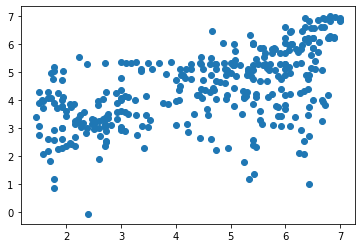

In [52]:
#stampo il grafico dei risultati sul test
plt.scatter(y_test, test_predictions)

In [53]:
#calcolo le metriche di valutazioni sul TEST
for metric in stampa_metriche(y_test, test_predictions):
    print(metric)

Correlazione di Spearman = 0.5721,p-value = 2.6694109039620713e-31
Correlazione di Pearson = 0.5608 p-value = 6.919123807876317e-30
MAE = 1.0764142368454503
MSE = 2.1113898531565254
RMSE = 1.4530622330638578
R2 = 0.26285613263276497


# Task 2: Regressione con n-grammi #
Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione
del testo basata su n-grammi di caratteri, parole e part-of-speech. Riportare i seguenti
risultati:
- testare diverse rappresentazioni del testo che variano rispetto alla lunghezza degli ngrammi utilizzati e/o rispetto al tipo di informazione utilizzata all’interno degli ngrammi (forme, lemmi, caratteri, part-of-speech) e valutare i diversi sistemi con un
processo di 5-fold cross validation condotto sul training set.
- valutazione sul test set ufficiale del miglior sistema rispetto ai risultati ottenuti con il
processo di 5-fold cross validation del punto sopra 


In [1]:
#definisco il path in cui si trovano i file connlu (output ottenuti da profiling UD)
conllu_dir = 'data/profiling_output/6902'

In [54]:
#varie funzioni per normalizzare il testo delle frasi e poi scomporle in token (da lab)
def get_digits(text):
    try:
      val = int(text)
    except:
      text = re.sub('\d', '@Dg', text)
      return text
    if val >= 0 and val < 2100:
      return str(val)
    else:
      return "DIGLEN_" + str(len(str(val)))

def normalize_text(word):
    if "http" in word or ("." in word and "/" in word):
      word = str("___URL___")
      return word
    if len(word) > 26:
      return "__LONG-LONG__"
    new_word = get_digits(word)
    if new_word != word:
      word = new_word
    if word[0].isupper():
      word = word.capitalize()
    else:
      word = word.lower()
    return word


def get_tokens_from_file(src_path):
    user_tokens = []
    lines_to_skip = 0
    take_pos = False
    take_lemma = False
    for line in open(src_path, 'r'):
        if line[0].isdigit():
            splitted_line = line.strip().split('\t')
            if '-' in splitted_line[0]:
                skip_ids = splitted_line[0].split('-')
                lines_to_skip = int(skip_ids[1]) - int(skip_ids[0]) + 1 # l'indice ci indica quali righe saltare
                take_pos = True # booleano che indica che dobbiamo prendere la pos della prossima parola
                take_lemma = True
                word = normalize_text(splitted_line[1])
                pos = splitted_line[3]
                lemma = splitted_line[2]
                token = {
                    'word': word,
                    'pos': pos,
                    'lemma': lemma
                }
                # print(f'Preso token {word}')
                user_tokens.append(token)
            else:
                if lines_to_skip == 0:
                    
                    word = normalize_text(splitted_line[1])
                    pos = splitted_line[3]
                    lemma = splitted_line[2]
                    token = {
                    'word': word,
                    'pos': pos,
                    'lemma': lemma
                }
                    user_tokens.append(token)
                if take_pos:
                    pos = splitted_line[3]
                    user_tokens[-1]['pos'] = pos
                    take_pos = False
                if take_lemma:
                    lemma = splitted_line[2]
                    user_tokens[-1]['lemma'] = lemma
                    take_lemma = False
                lines_to_skip = max(0, lines_to_skip-1)
    return user_tokens

def create_dataset(scores_dict):
    sentences = []
    scores = []
    
    for sent_id in scores_dict:
    
        score = scores_dict[sent_id]

        conllu_path = os.path.join(conllu_dir, f'{sent_id}.conllu')
        sentence_tokens = get_tokens_from_file(conllu_path)

        sentences.append(sentence_tokens)
        scores.append(score)
    
    return sentences, scores

In [55]:
#dal mio dizionario id:scores ricavo per train e test due liste, una che per ogni frase ha parola, lemma e pos corrispondente
#l'altra ha i punteggi gold relativi alle frasi
train_sentences, train_scores = create_dataset(train_scores_dict)
test_sentences, test_scores = create_dataset(test_scores_dict)

In [56]:
print('Training set:',len(train_sentences), len(train_scores))
print('Test set:', len(test_sentences), len(test_scores))

Training set: 1339 1339
Test set: 344 344


In [57]:
#esempio di frase divisa per parole/pos
train_sentences[0]

[{'word': 'Quando', 'pos': 'SCONJ', 'lemma': 'quando'},
 {'word': 'gli', 'pos': 'DET', 'lemma': 'il'},
 {'word': 'invitati', 'pos': 'NOUN', 'lemma': 'invitare'},
 {'word': 'erano', 'pos': 'AUX', 'lemma': 'essere'},
 {'word': 'in', 'pos': 'ADP', 'lemma': 'in'},
 {'word': 'ritardo', 'pos': 'NOUN', 'lemma': 'ritardo'},
 {'word': 'lui', 'pos': 'PRON', 'lemma': 'lui'},
 {'word': 'avvertiva', 'pos': 'VERB', 'lemma': 'avvertire'},
 {'word': 'sempre', 'pos': 'ADV', 'lemma': 'sempre'},
 {'word': 'il', 'pos': 'DET', 'lemma': 'il'},
 {'word': 'ristorante', 'pos': 'NOUN', 'lemma': 'ristorante'},
 {'word': '.', 'pos': 'PUNCT', 'lemma': '.'}]

In [58]:
train_scores[0]

5.285714286

### Formazione n-grammi

In [59]:
#funzione per estrazione di n-grammi di parole (da lab4)

def extract_word_ngrams(word_ngrams, sentence, el, n):
    # creiamo una lista con tutte le parole scorrendo la lista
    all_words = []
    for token in sentence:
        all_words.append(token[el])
    
    # scorriamo la lista delle parole e estraiamo gli n-grammi
    for i in range(0, len(all_words) - n + 1):
        ngram_words = all_words[i: i + n]
        ngram = f'{el.upper()}_{n}_' + '_'.join(ngram_words)
        if ngram not in word_ngrams:
            word_ngrams[ngram] = 1
        else:
            word_ngrams[ngram] += 1
    
    return word_ngrams

In [60]:
#esempio
extract_word_ngrams(dict(), train_sentences[0], 'word', 3)

{'WORD_3_Quando_gli_invitati': 1,
 'WORD_3_gli_invitati_erano': 1,
 'WORD_3_invitati_erano_in': 1,
 'WORD_3_erano_in_ritardo': 1,
 'WORD_3_in_ritardo_lui': 1,
 'WORD_3_ritardo_lui_avvertiva': 1,
 'WORD_3_lui_avvertiva_sempre': 1,
 'WORD_3_avvertiva_sempre_il': 1,
 'WORD_3_sempre_il_ristorante': 1,
 'WORD_3_il_ristorante_.': 1}

In [61]:
# funzione per estrazione di n-grammi di caratteri (da lab4)

def extract_char_ngrams(char_ngrams, sentence, n):
    
    # creiamo una lista con tutte le parole
    all_words = []
    for token in sentence:
        all_words.append(token['word'])

    # creiamo una stringa che contenga tutte le parole separate tra spazi perchè vogliamo scorrere i caratteri
    all_words = ' '.join(all_words)
    
    # scorriamo la stringa ed estraiamo gli n-grammi di caratteri
    for i in range(0, len(all_words) - n + 1):
        ngram_chars = all_words[i:i + n]
        ngram = f'CHAR_{n}_' + ngram_chars

        if ngram not in char_ngrams:
            char_ngrams[ngram] = 1
        else:
            char_ngrams[ngram] += 1
    
    return char_ngrams

In [62]:
#esempio
extract_char_ngrams(dict(), train_sentences[0], 2)

{'CHAR_2_Qu': 1,
 'CHAR_2_ua': 1,
 'CHAR_2_an': 3,
 'CHAR_2_nd': 1,
 'CHAR_2_do': 2,
 'CHAR_2_o ': 3,
 'CHAR_2_ g': 1,
 'CHAR_2_gl': 1,
 'CHAR_2_li': 1,
 'CHAR_2_i ': 3,
 'CHAR_2_ i': 3,
 'CHAR_2_in': 2,
 'CHAR_2_nv': 1,
 'CHAR_2_vi': 1,
 'CHAR_2_it': 2,
 'CHAR_2_ta': 2,
 'CHAR_2_at': 1,
 'CHAR_2_ti': 2,
 'CHAR_2_ e': 1,
 'CHAR_2_er': 2,
 'CHAR_2_ra': 2,
 'CHAR_2_no': 1,
 'CHAR_2_n ': 1,
 'CHAR_2_ r': 2,
 'CHAR_2_ri': 2,
 'CHAR_2_ar': 1,
 'CHAR_2_rd': 1,
 'CHAR_2_ l': 1,
 'CHAR_2_lu': 1,
 'CHAR_2_ui': 1,
 'CHAR_2_ a': 1,
 'CHAR_2_av': 1,
 'CHAR_2_vv': 1,
 'CHAR_2_ve': 1,
 'CHAR_2_rt': 1,
 'CHAR_2_iv': 1,
 'CHAR_2_va': 1,
 'CHAR_2_a ': 1,
 'CHAR_2_ s': 1,
 'CHAR_2_se': 1,
 'CHAR_2_em': 1,
 'CHAR_2_mp': 1,
 'CHAR_2_pr': 1,
 'CHAR_2_re': 1,
 'CHAR_2_e ': 2,
 'CHAR_2_il': 1,
 'CHAR_2_l ': 1,
 'CHAR_2_is': 1,
 'CHAR_2_st': 1,
 'CHAR_2_to': 1,
 'CHAR_2_or': 1,
 'CHAR_2_nt': 1,
 'CHAR_2_te': 1,
 'CHAR_2_ .': 1}

In [63]:
#uso la stessa funzione degli n-grammi di parole per estrarre gli n-grammi di pos
#esempio
extract_word_ngrams(dict(), train_sentences[0], 'pos', 3)

{'POS_3_SCONJ_DET_NOUN': 1,
 'POS_3_DET_NOUN_AUX': 1,
 'POS_3_NOUN_AUX_ADP': 1,
 'POS_3_AUX_ADP_NOUN': 1,
 'POS_3_ADP_NOUN_PRON': 1,
 'POS_3_NOUN_PRON_VERB': 1,
 'POS_3_PRON_VERB_ADV': 1,
 'POS_3_VERB_ADV_DET': 1,
 'POS_3_ADV_DET_NOUN': 1,
 'POS_3_DET_NOUN_PUNCT': 1}

In [64]:
#uso la stessa funzione degli n-grammi di parole per estrarre gli n-grammi di lemmi
#esempio
extract_word_ngrams(dict(), train_sentences[0], 'lemma', 3)

{'LEMMA_3_quando_il_invitare': 1,
 'LEMMA_3_il_invitare_essere': 1,
 'LEMMA_3_invitare_essere_in': 1,
 'LEMMA_3_essere_in_ritardo': 1,
 'LEMMA_3_in_ritardo_lui': 1,
 'LEMMA_3_ritardo_lui_avvertire': 1,
 'LEMMA_3_lui_avvertire_sempre': 1,
 'LEMMA_3_avvertire_sempre_il': 1,
 'LEMMA_3_sempre_il_ristorante': 1,
 'LEMMA_3_il_ristorante_.': 1}

In [65]:
#funzione di normalizzazione del numero di ngrammi
def normalize_ngrams(ngrams_dict, doc_len):
    for ngram in ngrams_dict:
        ngrams_dict[ngram] = ngrams_dict[ngram]/float(doc_len)

In [66]:
#funzione per estrazione features di ngrammi di CARATTERI da 2 a 6 e formazione liste

def extract_ngrams_chars_features(dataset):
    dataset_features2c = []
    dataset_features3c = []
    dataset_features4c = []
    for sentence in dataset: #estraggo gli n-grammi 
        char_1grams = extract_char_ngrams(dict(), sentence, 1)
        char_2grams = extract_char_ngrams(dict(), sentence, 2)
        char_3grams = extract_char_ngrams(dict(), sentence, 3)
        char_4grams = extract_char_ngrams(dict(), sentence, 4)                

        num_chars = 0
        for token in sentence:
            num_chars = num_chars + len(token['word'])
            
        #normalizzo gli n-grammi 
        normalize_ngrams(char_1grams, num_chars)
        normalize_ngrams(char_2grams, num_chars)
        normalize_ngrams(char_3grams, num_chars)
        normalize_ngrams(char_4grams, num_chars)
        
        sf_2c = char_1grams | char_2grams
        sf_3c = char_1grams | char_2grams | char_3grams
        sf_4c = char_1grams | char_2grams | char_3grams | char_4grams
        
        dataset_features2c.append(sf_2c)
        dataset_features3c.append(sf_3c)
        dataset_features4c.append(sf_4c)
    return dataset_features2c, dataset_features3c, dataset_features4c

In [67]:
#funzione per estrazione features di ngrammi di PAROLE da 1 a 6 e formazione liste

def extract_ngrams_words_features(dataset):
    dataset_features2w = []
    dataset_features3w = []
    dataset_features4w = []
    for sentence in dataset: #estraggo gli n-grammi 
        word_1grams = extract_word_ngrams(dict(), sentence, 'word', 1)
        word_2grams = extract_word_ngrams(dict(), sentence, 'word', 2)
        word_3grams = extract_word_ngrams(dict(), sentence, 'word', 3)
        word_4grams = extract_word_ngrams(dict(), sentence, 'word', 4)             

        num_words = len(sentence)
            
        #normalizzo gli n-grammi 
        normalize_ngrams(word_1grams, num_words)
        normalize_ngrams(word_2grams, num_words)
        normalize_ngrams(word_3grams, num_words)
        normalize_ngrams(word_4grams, num_words)
        
        sf_2w = word_1grams | word_2grams 
        sf_3w = word_1grams | word_2grams | word_3grams
        sf_4w = word_1grams | word_2grams | word_3grams | word_4grams 

        dataset_features2w.append(sf_2w)
        dataset_features3w.append(sf_3w)
        dataset_features4w.append(sf_4w)
    return dataset_features2w, dataset_features3w, dataset_features4w

In [68]:
#ottengo le features degli n-grammi di parole e caratteri su training e test set
train_features2c, train_features3c, train_features4c = extract_ngrams_chars_features(train_sentences)
test_features2c, test_features3c, test_features4c = extract_ngrams_chars_features(test_sentences)

train_features2w, train_features3w, train_features4w, = extract_ngrams_words_features(train_sentences)
test_features2w, test_features3w, test_features4w= extract_ngrams_words_features(test_sentences)

In [69]:
#esempio di features con 3-grammi di caratteri
train_features3c[20]

{'CHAR_1_L': 0.047619047619047616,
 'CHAR_1_e': 0.09523809523809523,
 'CHAR_1_ ': 0.19047619047619047,
 'CHAR_1_m': 0.09523809523809523,
 'CHAR_1_u': 0.09523809523809523,
 'CHAR_1_c': 0.09523809523809523,
 'CHAR_1_h': 0.09523809523809523,
 'CHAR_1_a': 0.047619047619047616,
 'CHAR_1_n': 0.09523809523809523,
 'CHAR_1_o': 0.09523809523809523,
 'CHAR_1_g': 0.09523809523809523,
 'CHAR_1_i': 0.047619047619047616,
 'CHAR_1_t': 0.047619047619047616,
 'CHAR_1_.': 0.047619047619047616,
 'CHAR_2_Le': 0.047619047619047616,
 'CHAR_2_e ': 0.09523809523809523,
 'CHAR_2_ m': 0.09523809523809523,
 'CHAR_2_mu': 0.09523809523809523,
 'CHAR_2_uc': 0.047619047619047616,
 'CHAR_2_cc': 0.047619047619047616,
 'CHAR_2_ch': 0.047619047619047616,
 'CHAR_2_he': 0.047619047619047616,
 'CHAR_2_ h': 0.047619047619047616,
 'CHAR_2_ha': 0.047619047619047616,
 'CHAR_2_an': 0.047619047619047616,
 'CHAR_2_nn': 0.047619047619047616,
 'CHAR_2_no': 0.047619047619047616,
 'CHAR_2_o ': 0.09523809523809523,
 'CHAR_2_ug': 0.047

In [70]:
#esempio di features con 3-grammi di parole
train_features3w[20]

{'WORD_1_Le': 0.2,
 'WORD_1_mucche': 0.2,
 'WORD_1_hanno': 0.2,
 'WORD_1_muggito': 0.2,
 'WORD_1_.': 0.2,
 'WORD_2_Le_mucche': 0.2,
 'WORD_2_mucche_hanno': 0.2,
 'WORD_2_hanno_muggito': 0.2,
 'WORD_2_muggito_.': 0.2,
 'WORD_3_Le_mucche_hanno': 0.2,
 'WORD_3_mucche_hanno_muggito': 0.2,
 'WORD_3_hanno_muggito_.': 0.2}

In [71]:
test_features3w[20]

{'WORD_1_Mentre': 0.08333333333333333,
 'WORD_1_il': 0.08333333333333333,
 'WORD_1_pubblico': 0.08333333333333333,
 'WORD_1_applaudiva': 0.08333333333333333,
 'WORD_1_io': 0.08333333333333333,
 'WORD_1_continuavo': 0.08333333333333333,
 'WORD_1_a': 0.08333333333333333,
 'WORD_1_gioire': 0.08333333333333333,
 'WORD_1_di': 0.08333333333333333,
 'WORD_1_tanto': 0.08333333333333333,
 'WORD_1_successo': 0.08333333333333333,
 'WORD_1_.': 0.08333333333333333,
 'WORD_2_Mentre_il': 0.08333333333333333,
 'WORD_2_il_pubblico': 0.08333333333333333,
 'WORD_2_pubblico_applaudiva': 0.08333333333333333,
 'WORD_2_applaudiva_io': 0.08333333333333333,
 'WORD_2_io_continuavo': 0.08333333333333333,
 'WORD_2_continuavo_a': 0.08333333333333333,
 'WORD_2_a_gioire': 0.08333333333333333,
 'WORD_2_gioire_di': 0.08333333333333333,
 'WORD_2_di_tanto': 0.08333333333333333,
 'WORD_2_tanto_successo': 0.08333333333333333,
 'WORD_2_successo_.': 0.08333333333333333,
 'WORD_3_Mentre_il_pubblico': 0.08333333333333333,
 'W

In [72]:
#funzione per estrazione features di ngrammi di POS da 2 a 6 e formazione liste

def extract_ngrams_pos_features(dataset):
    dataset_features2p = []
    dataset_features3p = []
    dataset_features4p = []
    for sentence in dataset: #estraggo gli n-grammi 
        word_1grams = extract_word_ngrams(dict(), sentence, 'pos', 1)
        word_2grams = extract_word_ngrams(dict(), sentence, 'pos', 2)
        word_3grams = extract_word_ngrams(dict(), sentence, 'pos', 3)
        word_4grams = extract_word_ngrams(dict(), sentence, 'pos', 4)   

        num_pos = []
        for token in sentence:
            if token['pos'] not in num_pos:
                num_pos.append(token['pos'])
        pos_tot = len(num_pos)          
            
        #normalizzo gli n-grammi 
        normalize_ngrams(word_1grams, pos_tot)
        normalize_ngrams(word_2grams, pos_tot)
        normalize_ngrams(word_3grams, pos_tot)
        normalize_ngrams(word_4grams, pos_tot)
        
        sf_2 = word_1grams | word_2grams 
        sf_3 = word_1grams | word_2grams | word_3grams
        sf_4 = word_1grams | word_2grams | word_3grams | word_4grams 
        
        dataset_features2p.append(sf_2)
        dataset_features3p.append(sf_3)
        dataset_features4p.append(sf_4)
    return dataset_features2p, dataset_features3p, dataset_features4p

In [73]:
#ottengo le features degli n-grammi di pos
train_features2p, train_features3p, train_features4p = extract_ngrams_pos_features(train_sentences)
test_features2p, test_features3p, test_features4p= extract_ngrams_pos_features(test_sentences)

In [74]:
train_features2p[20]

{'POS_1_DET': 0.2,
 'POS_1_NOUN': 0.2,
 'POS_1_AUX': 0.2,
 'POS_1_VERB': 0.2,
 'POS_1_PUNCT': 0.2,
 'POS_2_DET_NOUN': 0.2,
 'POS_2_NOUN_AUX': 0.2,
 'POS_2_AUX_VERB': 0.2,
 'POS_2_VERB_PUNCT': 0.2}

In [75]:
#funzione per estrazione features di ngrammi di LEMMI da 2 a 6 e formazione liste

def extract_ngrams_lemma_features(dataset):
    dataset_features2l = []
    dataset_features3l = []
    dataset_features4l = []
    for sentence in dataset: #estraggo gli n-grammi 
        word_1grams = extract_word_ngrams(dict(), sentence, 'lemma', 1)
        word_2grams = extract_word_ngrams(dict(), sentence, 'lemma', 2)
        word_3grams = extract_word_ngrams(dict(), sentence, 'lemma', 3)
        word_4grams = extract_word_ngrams(dict(), sentence, 'lemma', 4)  

        num_lemmi = []
        for token in sentence:
            if token['lemma'] not in num_lemmi:
                num_lemmi.append(token['lemma'])
        num_lem = len(num_lemmi)         
            
        #normalizzo gli n-grammi
        normalize_ngrams(word_1grams, num_lem)
        normalize_ngrams(word_2grams, num_lem)
        normalize_ngrams(word_3grams, num_lem)
        normalize_ngrams(word_4grams, num_lem)
        
        sf_2 = word_1grams | word_2grams 
        sf_3 = word_1grams | word_2grams | word_3grams
        sf_4 = word_1grams | word_2grams | word_3grams | word_4grams 
        
        dataset_features2l.append(sf_2)
        dataset_features3l.append(sf_3)
        dataset_features4l.append(sf_4)
    return dataset_features2l, dataset_features3l, dataset_features4l

In [76]:
# ottengo le features degli n-grammi di  lemmi
train_features2l, train_features3l, train_features4l = extract_ngrams_lemma_features(train_sentences)
test_features2l, test_features3l, test_features4l = extract_ngrams_lemma_features(test_sentences)

In [77]:
#funzione per ottenere il numero di features
def get_num_features(dataset):
    all_features = set()
    for user_dict in dataset:
        all_features.update(list(user_dict.keys()))
    return len(all_features)

In [78]:
# Stampo il numero di features per diverse tipologie di n-grammi per vedere la differenza
print("---CARATTERI---")
print(f'Numero features 2 char: {get_num_features(train_features2c)}')
print(f'Numero features 3 char: {get_num_features(train_features3c)}')
print(f'Numero features 4 char: {get_num_features(train_features4c)}')
print("---PAROLE---")
print(f'Numero features 2 word: {get_num_features(train_features2w)}')
print(f'Numero features 3 word: {get_num_features(train_features3w)}')
print(f'Numero features 4 word: {get_num_features(train_features4w)}')
print("---POS---")
print(f'Numero features 2 pos: {get_num_features(train_features2p)}')
print(f'Numero features 3 pos: {get_num_features(train_features3p)}')
print(f'Numero features 4 pos: {get_num_features(train_features4p)}')
print("---LEMMI---")
print(f'Numero features 2 lemmi: {get_num_features(train_features2l)}')
print(f'Numero features 3 lemmi: {get_num_features(train_features3l)}')
print(f'Numero features 4 lemmi: {get_num_features(train_features4l)}')

---CARATTERI---
Numero features 2 char: 380
Numero features 3 char: 2159
Numero features 4 char: 6794
---PAROLE---
Numero features 2 word: 4408
Numero features 3 word: 8537
Numero features 4 word: 13133
---POS---
Numero features 2 pos: 109
Numero features 3 pos: 372
Numero features 4 pos: 859
---LEMMI---
Numero features 2 lemmi: 3605
Numero features 3 lemmi: 7184
Numero features 4 lemmi: 11212


In [79]:
def filter_features(train_features, min_occurrences):
    
    # contiamo ogni feature in quanti user diversi compare
    features_counter = dict()
    for user_dict in train_features:
        for feature in user_dict:
            if feature in features_counter:
                features_counter[feature] += 1
            else:
                features_counter[feature] = 1

    # per ogni user, togliamo le features che compaiono in meno di "min_occurrences" utenti
    for user_dict in train_features:
        user_features = list(user_dict.keys())
        for feature in user_features:
            if features_counter[feature] < min_occurrences:
                user_dict.pop(feature)
                
    return train_features

In [80]:
#filtro le features per lemmi e parole con min_occurrences = 2
for el in [train_features2l, train_features3l, train_features4l, train_features2w, train_features3w, train_features4w]:
    el = filter_features(el, 2)

In [81]:
#filtro le features per i caratteri con min_occurrences = 3
for el in [train_features2c, train_features3c, train_features4c]:
    el = filter_features(el, 3)

In [82]:
# Stampo il numero di features per diverse tipologie di n-grammi per vedere la differenza
print("---CARATTERI---")
print(f'Numero features 2 char: {get_num_features(train_features2c)}')
print(f'Numero features 3 char: {get_num_features(train_features3c)}')
print(f'Numero features 4 char: {get_num_features(train_features4c)}')
print("---PAROLE---")
print(f'Numero features 2 word: {get_num_features(train_features2w)}')
print(f'Numero features 3 word: {get_num_features(train_features3w)}')
print(f'Numero features 4 word: {get_num_features(train_features4w)}')
print("---POS---")
print(f'Numero features 2 pos: {get_num_features(train_features2p)}')
print(f'Numero features 3 pos: {get_num_features(train_features3p)}')
print(f'Numero features 4 pos: {get_num_features(train_features4p)}')
print("---LEMMI---")
print(f'Numero features 2 lemmi: {get_num_features(train_features2l)}')
print(f'Numero features 3 lemmi: {get_num_features(train_features3l)}')
print(f'Numero features 4 lemmi: {get_num_features(train_features4l)}')

---CARATTERI---
Numero features 2 char: 378
Numero features 3 char: 2062
Numero features 4 char: 6159
---PAROLE---
Numero features 2 word: 3006
Numero features 3 word: 5083
Numero features 4 word: 6916
---POS---
Numero features 2 pos: 109
Numero features 3 pos: 372
Numero features 4 pos: 859
---LEMMI---
Numero features 2 lemmi: 2724
Numero features 3 lemmi: 4824
Numero features 4 lemmi: 6747


## N-GRAMMI DI CARATTERI

In [83]:
vectorizer_ngrams = DictVectorizer()
scaler_ngrams = MaxAbsScaler()

In [84]:
train_scores = np.asarray(train_scores)

In [691]:
#ciclo che per ogni dataset di n-grammi calcola tutto e ritorna i risultati su un file di testo esterno

ngrams = [train_features2c, train_features3c, train_features4c]
num_list = 2

for lista in ngrams:
    
    print(f"----- {num_list}grammi di caratteri -----")
    print()
    #creo la matrice delle features
    X_train_ngrams = vectorizer_ngrams.fit_transform(lista)
    X_train_ngrams = scaler_ngrams.fit_transform(X_train_ngrams)

    #faccio il fit e predict sul TRAIN
    svr_ngrams = LinearSVR(C=0.1, dual=True, epsilon=0.5, loss='squared_epsilon_insensitive', max_iter=10000)
    svr_ngrams.fit(X_train_ngrams, train_scores)
    train_predictions_ngrams = svr_ngrams.predict(X_train_ngrams)

    #stampo le metriche di valutazione sul TRAIN
    print("R2 sul training set --->", r2_score(train_scores, train_predictions_ngrams))
    print()
    print("Risultati di r2 per ogni fold confrontato con la baseline:")
    do_5fcv(X_train_ngrams,train_scores)
    print()

    num_list+=1

----- 2grammi di caratteri -----

R2 sul training set ---> 0.4533591188489797

Risultati di r2 per ogni fold confrontato con la baseline:
R2 fold 1: 0.3663337235484134 - Baseline: -3.9829320552797753e-07
R2 fold 2: 0.2702127457204493 - Baseline: -0.0001651885378686213
R2 fold 3: 0.2680972181679995 - Baseline: -0.005663532786817527
R2 fold 4: 0.30895014179149616 - Baseline: -0.0006676591670384813
R2 fold 5: 0.32775376439532056 - Baseline: -0.00825695720269115
R2 tra gold e predizioni totali: 0.3094101083632169

----- 3grammi di caratteri -----

R2 sul training set ---> 0.5544698445817735

Risultati di r2 per ogni fold confrontato con la baseline:
R2 fold 1: 0.27336666052059033 - Baseline: -3.9829320552797753e-07
R2 fold 2: 0.22931227258144782 - Baseline: -0.0001651885378686213
R2 fold 3: 0.23628261232265102 - Baseline: -0.005663532786817527
R2 fold 4: 0.3027859694991589 - Baseline: -0.0006676591670384813
R2 fold 5: 0.3308827559296955 - Baseline: -0.00825695720269115
R2 tra gold e prediz

### Test sul migliore: 2grammi di caratteri

In [692]:
#creo la matrice delle features
X_train_ngrams = vectorizer_ngrams.fit_transform(train_features2c)
X_train_ngrams = scaler_ngrams.fit_transform(X_train_ngrams)
#faccio il fit sul TRAIN
svr_ngrams = LinearSVR(C=0.1, dual=True, epsilon=0.5, loss='squared_epsilon_insensitive', max_iter=10000)
svr_ngrams.fit(X_train_ngrams, train_scores)

LinearSVR(C=0.1, epsilon=0.5, loss='squared_epsilon_insensitive',
          max_iter=10000)

In [693]:
#ottengo la matrice delle features per i 2-grammi di caratteri
X_test_ngrams = vectorizer_ngrams.transform(test_features2c)
X_test_ngrams = scaler_ngrams.transform(X_test_ngrams)
X_test_ngrams

<344x378 sparse matrix of type '<class 'numpy.float64'>'
	with 23014 stored elements in Compressed Sparse Row format>

In [694]:
#faccio le predizioni sul test
test_predictions_ngrams = svr_ngrams.predict(X_test_ngrams)
test_predictions_ngrams[:5]

array([4.24556891, 4.96727499, 5.44768141, 4.19812056, 3.57713162])

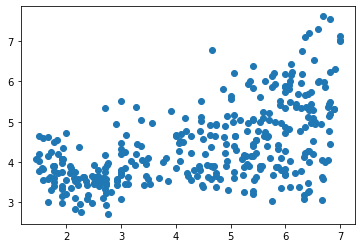

In [695]:
#stampo il grafico
plt.scatter(test_scores, test_predictions_ngrams)

In [696]:
for metric in stampa_metriche(test_scores, test_predictions_ngrams):
    print(metric)

Correlazione di Spearman = 0.5342,p-value = 8.936426469038122e-27
Correlazione di Pearson = 0.55 p-value = 1.3882987302756891e-28
MAE = 1.1686199602728746
MSE = 2.003326648203577
RMSE = 1.4153892214523809
R2 = 0.3005839490755813


### Calcolo i risultati di un dummy regressor come baseline

In [697]:
dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(X_test_ngrams, y_test)
dummy_predictions = dummy_regressor.predict(X_test_ngrams)

In [698]:
for metric in stampa_metriche(test_scores, dummy_predictions):
    print(metric)

Correlazione di Spearman = nan,p-value = nan
Correlazione di Pearson = nan p-value = nan
MAE = 1.4977894929901638
MSE = 2.8642846350977775
RMSE = 1.6924197573586104
R2 = 0.0


c:\Users\lucre\anaconda3\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\Users\lucre\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


## N-GRAMMI di PAROLE

In [96]:
#stampo le valutazioni sul training set
ngramsw = [train_features2w, train_features3w, train_features4w]
num_list = 2


for lista in ngramsw:
    
    print(f"----- {num_list}grammi di parole token -----")
    print()
    #creo la matrice delle features
    X_train_ngrams = vectorizer_ngrams.fit_transform(lista)
    X_train_ngrams = scaler_ngrams.fit_transform(X_train_ngrams)

    #faccio il fit e predict sul TRAIN
    svr_ngrams = LinearSVR(C=0.1, dual=True, epsilon=0.5, loss='squared_epsilon_insensitive', max_iter=10000)
    svr_ngrams.fit(X_train_ngrams, y_train)
    train_predictions_ngrams = svr_ngrams.predict(X_train_ngrams)

    #stampo le metriche di valutazione sul TRAIN
    print("R2 sul training set --->", r2_score(y_train, train_predictions_ngrams))
    print()
    print("Risultati di r2 per ogni fold confrontato con la baseline:")
    do_5fcv(X_train_ngrams, train_scores)
    print()

    num_list+=1

----- 2grammi di parole token -----

R2 sul training set ---> 0.36075372045569065

Risultati di r2 per ogni fold confrontato con la baseline:
R2 fold 1: 0.25617096826755303 - Baseline: -3.9829320552797753e-07
R2 fold 2: 0.2094701592638405 - Baseline: -0.0001651885378686213
R2 fold 3: 0.25747039499716506 - Baseline: -0.005663532786817527
R2 fold 4: 0.28637788363006156 - Baseline: -0.0006676591670384813
R2 fold 5: 0.3254199366888797 - Baseline: -0.00825695720269115
R2 tra gold e predizioni totali: 0.2684542457744027

----- 3grammi di parole token -----

R2 sul training set ---> 0.438202683904524

Risultati di r2 per ogni fold confrontato con la baseline:
R2 fold 1: 0.1958022526385702 - Baseline: -3.9829320552797753e-07
R2 fold 2: 0.14914901242293455 - Baseline: -0.0001651885378686213
R2 fold 3: 0.22274407055023182 - Baseline: -0.005663532786817527
R2 fold 4: 0.24182076545418885 - Baseline: -0.0006676591670384813
R2 fold 5: 0.2818088973342834 - Baseline: -0.00825695720269115
R2 tra gold e

### Test sul miglior risultato: 2-grammi di parole
### BASELINE UFFICIALE

In [97]:
#creo la matrice delle features
X_train_ngrams = vectorizer_ngrams.fit_transform(train_features2w)
X_train_ngrams = scaler_ngrams.fit_transform(X_train_ngrams)
#faccio il fit sul TRAIN
svr_ngrams = LinearSVR(C=0.1, epsilon=0.5, loss='squared_epsilon_insensitive', dual=True, max_iter=10000)
svr_ngrams.fit(X_train_ngrams, train_scores)

LinearSVR(C=0.1, epsilon=0.5, loss='squared_epsilon_insensitive',
          max_iter=10000)

In [98]:
#inserisco le feature di test in un vettore e le normalizzo
X_test_ngrams = vectorizer_ngrams.transform(test_features2w)
X_test_ngrams = scaler_ngrams.transform(X_test_ngrams)
X_test_ngrams

<344x3006 sparse matrix of type '<class 'numpy.float64'>'
	with 6323 stored elements in Compressed Sparse Row format>

In [99]:
test_predictions_ngrams = svr_ngrams.predict(X_test_ngrams)
test_predictions_ngrams[:5]

array([4.55387748, 4.61740597, 5.44215935, 5.17080648, 3.51316138])

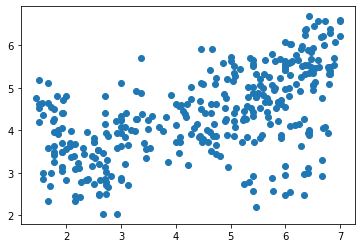

In [100]:
plt.scatter(test_scores, test_predictions_ngrams)

In [101]:
for metric in stampa_metriche(test_scores, test_predictions_ngrams):
    print(metric)

Correlazione di Spearman = 0.5629,p-value = 3.865417369276508e-30
Correlazione di Pearson = 0.5625 p-value = 4.3413834161561744e-30
MAE = 1.1004072057479495
MSE = 1.9775842885872188
RMSE = 1.4062660802946285
R2 = 0.3095713099338291


## N-GRAMMI DI POS

In [85]:
ngramsp = [train_features2p, train_features3p, train_features4p]
num_list = 2

for lista in ngramsp:
    
    print(f"----- {num_list}grammi di part-of-speech -----")
    print()
    #creo la matrice delle features
    X_train_ngrams = vectorizer_ngrams.fit_transform(lista)
    X_train_ngrams = scaler_ngrams.fit_transform(X_train_ngrams)

    #faccio il fit e predict sul TRAIN
    svr_ngrams = LinearSVR(C=0.1, dual=True, epsilon=0.5, loss='squared_epsilon_insensitive', max_iter=10000)
    svr_ngrams.fit(X_train_ngrams, y_train)
    train_predictions_ngrams = svr_ngrams.predict(X_train_ngrams)

    #stampo le metriche di valutazione sul TRAIN
    print("R2 sul training set --->", r2_score(y_train, train_predictions_ngrams))
    print()
    print("Risultati di r2 per ogni fold confrontato con la baseline:")
    do_5fcv(X_train_ngrams, train_scores)
    print()

    num_list+=1

----- 2grammi di part-of-speech -----

R2 sul training set ---> 0.0695915608818014

Risultati di r2 per ogni fold confrontato con la baseline:
R2 fold 1: 0.3008785151604827 - Baseline: -3.9829320552797753e-07
R2 fold 2: 0.271652009948527 - Baseline: -0.0001651885378686213
R2 fold 3: 0.30137747396711445 - Baseline: -0.005663532786817527
R2 fold 4: 0.2927152639781121 - Baseline: -0.0006676591670384813
R2 fold 5: 0.3386025347668141 - Baseline: -0.00825695720269115
R2 tra gold e predizioni totali: 0.3019862157184783

----- 3grammi di part-of-speech -----

R2 sul training set ---> 0.11030160708317294

Risultati di r2 per ogni fold confrontato con la baseline:
R2 fold 1: 0.3002104497575213 - Baseline: -3.9829320552797753e-07
R2 fold 2: 0.2923304119735274 - Baseline: -0.0001651885378686213
R2 fold 3: 0.2984637777302863 - Baseline: -0.005663532786817527
R2 fold 4: 0.31385489715776427 - Baseline: -0.0006676591670384813
R2 fold 5: 0.3468116972501424 - Baseline: -0.00825695720269115
R2 tra gold e

### Test sul miglior risultato: 3-grammi pos

In [91]:
#creo la matrice delle features
X_train_ngrams = vectorizer_ngrams.fit_transform(train_features3p)
X_train_ngrams = scaler_ngrams.fit_transform(X_train_ngrams)
#faccio il fit sul TRAIN
svr_ngrams = LinearSVR(C=0.1, epsilon=0.5, loss='squared_epsilon_insensitive', dual=True, max_iter=10000)
svr_ngrams.fit(X_train_ngrams, train_scores)

LinearSVR(C=0.1, epsilon=0.5, loss='squared_epsilon_insensitive',
          max_iter=10000)

In [92]:
X_test_ngrams = vectorizer_ngrams.transform(test_features3p)
X_test_ngrams = scaler_ngrams.transform(X_test_ngrams)
X_test_ngrams

<344x372 sparse matrix of type '<class 'numpy.float64'>'
	with 8328 stored elements in Compressed Sparse Row format>

In [93]:
test_predictions_ngrams = svr_ngrams.predict(X_test_ngrams)
test_predictions_ngrams[:5]

array([3.98159737, 4.51420174, 5.7411849 , 4.46069126, 2.40449624])

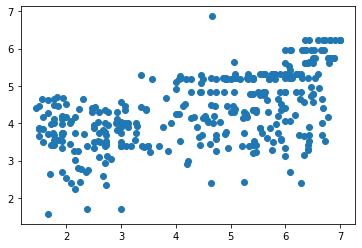

In [94]:
plt.scatter(test_scores, test_predictions_ngrams)

In [95]:
for metric in stampa_metriche(test_scores, test_predictions_ngrams):
    print(metric)

Correlazione di Spearman = 0.5409,p-value = 1.5619460548174028e-27
Correlazione di Pearson = 0.5524 p-value = 7.217589016979641e-29
MAE = 1.1567044248645881
MSE = 2.0055638247187457
RMSE = 1.416179305285438
R2 = 0.29980288964882085


## N-GRAMMI DI LEMMI

In [711]:
ngramsl = [train_features2l, train_features3l, train_features4l]
num_list = 2

for lista in ngramsl:
    
    print(f"----- {num_list}grammi di part-of-speech -----")
    print()
    #creo la matrice delle features
    X_train_ngrams = vectorizer_ngrams.fit_transform(lista)
    X_train_ngrams = scaler_ngrams.fit_transform(X_train_ngrams)

    #faccio il fit e predict sul TRAIN
    svr_ngrams = LinearSVR(C=0.1, dual=True, epsilon=0.5, loss='squared_epsilon_insensitive', max_iter=10000)
    svr_ngrams.fit(X_train_ngrams, y_train)
    train_predictions_ngrams = svr_ngrams.predict(X_train_ngrams)

    #stampo le metriche di valutazione sul TRAIN
    print("R2 sul training set --->", r2_score(y_train, train_predictions_ngrams))
    print()
    print("Risultati di r2 per ogni fold confrontato con la baseline:")
    do_5fcv(X_train_ngrams, train_scores)
    print()

    num_list+=1

----- 2grammi di part-of-speech -----

R2 sul training set ---> 0.31708870804374034

Risultati di r2 per ogni fold confrontato con la baseline:
R2 fold 1: 0.1889261854893184 - Baseline: -3.9829320552797753e-07
R2 fold 2: 0.15527496448162403 - Baseline: -0.0001651885378686213
R2 fold 3: 0.17901488700028623 - Baseline: -0.005663532786817527
R2 fold 4: 0.22470591055379774 - Baseline: -0.0006676591670384813
R2 fold 5: 0.26787629082244824 - Baseline: -0.00825695720269115
R2 tra gold e predizioni totali: 0.20480192177375778

----- 3grammi di part-of-speech -----

R2 sul training set ---> 0.4024246472037796

Risultati di r2 per ogni fold confrontato con la baseline:
R2 fold 1: 0.14238988097444805 - Baseline: -3.9829320552797753e-07
R2 fold 2: 0.11626036019101638 - Baseline: -0.0001651885378686213
R2 fold 3: 0.1444963804574414 - Baseline: -0.005663532786817527
R2 fold 4: 0.1851532341019031 - Baseline: -0.0006676591670384813
R2 fold 5: 0.23191091944384767 - Baseline: -0.00825695720269115
R2 tra

### Test sul miglior risultato: 2-grmami di lemmi

In [712]:
#creo la matrice delle features
X_train_ngrams = vectorizer_ngrams.fit_transform(train_features2l)
X_train_ngrams = scaler_ngrams.fit_transform(X_train_ngrams)
#faccio il fit sul TRAIN
svr_ngrams = LinearSVR(C=0.1, epsilon=0.5, loss='squared_epsilon_insensitive', dual=True, max_iter=10000)
svr_ngrams.fit(X_train_ngrams, train_scores)

LinearSVR(C=0.1, epsilon=0.5, loss='squared_epsilon_insensitive',
          max_iter=10000)

In [713]:
X_test_ngrams = vectorizer_ngrams.transform(test_features2l)
X_test_ngrams = scaler_ngrams.transform(X_test_ngrams)
X_test_ngrams

<344x2724 sparse matrix of type '<class 'numpy.float64'>'
	with 6371 stored elements in Compressed Sparse Row format>

In [714]:
test_predictions_ngrams = svr_ngrams.predict(X_test_ngrams)
test_predictions_ngrams[:5]

array([4.81089954, 4.87045997, 4.52513286, 5.22017401, 3.51246484])

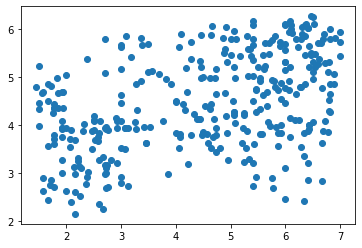

In [715]:
plt.scatter(test_scores, test_predictions_ngrams)

In [716]:
for metric in stampa_metriche(test_scores, test_predictions_ngrams):
    print(metric)

Correlazione di Spearman = 0.4385,p-value = 1.3420212175931533e-17
Correlazione di Pearson = 0.4517 p-value = 1.0670714571006477e-18
MAE = 1.2386813147392948
MSE = 2.333935171095472
RMSE = 1.5277222166007378
R2 = 0.18515948362939183


# Task 3: Regressione con Word Embeddings #
Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione
del testo costruita attraverso l’uso dei word embedding
(http://www.italianlp.it/resources/italian-word-embeddings/). Riportare i seguenti risultati:
- testare diverse rappresentazioni del testo che variano rispetto al modo di combinare gli
embedding delle singole parole e/o rispetto alle categorie grammaticali delle parole
prese in considerazione. Valutare i diversi sistemi con un processo di 5-fold cross
validation condotto sul training set.
- valutazione sul test set ufficiale del miglior sistema rispetto ai risultati ottenuti con il
processo di 5-fold cross validation del punto sopra 

In [102]:
import sqlite3

#accedo agli embeddings
conn = sqlite3.connect("data/embeddings/itwac128.sqlite")
c = conn.cursor()

embeddings = {}

#creo un dizionario "parola": array con i valori degli embeddings
for row in c.execute("SELECT * from store"):
    embeddings[row[0]] = np.asarray(row[1:])

c.close()

In [103]:
#visualizzo un esempio
embeddings['il'];

In [104]:
#funzione per calcolare la media degli embeddings

def compute_embeddings_mean(user_embeddings):
    sum_array = np.sum(user_embeddings, axis=0)
    mean_array = np.divide(sum_array, len(user_embeddings))
    return mean_array

In [105]:
#funzione che controlla se gli embeddings di una parola sono disponibili
# se sì ne calcola la media, se no crea un vettore di tutti 0 al posto degli embeddings

def compute_all_embeddings_mean(sentence_tokens):
    sentence_embeddings = []
    
    for token in sentence_tokens:
        word = token['word']
        if word in embeddings:
            sentence_embeddings.append(embeddings[word])
    
    if len(sentence_embeddings) == 0:
        sentence_embeddings = [np.zeros(128)]
    else:
        sentence_embeddings = compute_embeddings_mean(sentence_embeddings)
    return sentence_embeddings

In [106]:
#funzione che estrae gli embeddings delle parole di una certa frase

def extract_embedding_features(dataset):
    dataset_features = []
    for sentence in dataset:
        sentence_embeddings = compute_all_embeddings_mean(sentence)
        dataset_features.append(sentence_embeddings)
    return dataset_features

In [107]:
train_features_embeddings = extract_embedding_features(train_sentences)

In [108]:
#normalizzazione
scaler_embeddings = MinMaxScaler()
X_train_embeddings = scaler_embeddings.fit_transform(train_features_embeddings)

In [109]:
#fit del modello sul train
svr_embeddings = LinearSVR(C=0.1, epsilon=0.5, loss='squared_epsilon_insensitive', dual=False, max_iter=10000)
svr_embeddings.fit(X_train_embeddings, train_scores)
#predizioni sul train
train_predictions_embeddings = svr_embeddings.predict(X_train_embeddings)

In [110]:
#stampo R2 sul training set
print('R2 sul training set --->', r2_score(train_scores, train_predictions_embeddings))

R2 sul training set ---> 0.36541272771104727


In [111]:
#stampo i risultati della 5fold cross valdation sul training set
do_5fcv(X_train_embeddings, train_scores)

R2 fold 1: 0.3015653862067921 - Baseline: -3.9829320552797753e-07
R2 fold 2: 0.22843980845882805 - Baseline: -0.0001651885378686213
R2 fold 3: 0.29200538478436544 - Baseline: -0.005663532786817527
R2 fold 4: 0.3054658693073806 - Baseline: -0.0006676591670384813
R2 fold 5: 0.3323544743768819 - Baseline: -0.00825695720269115
R2 tra gold e predizioni totali: 0.29329854718661585


In [112]:
#estraggo gli embeddings del test set con la stessa metodologia
test_features_embeddings = extract_embedding_features(test_sentences)
X_test_embeddings = scaler_embeddings.transform(test_features_embeddings)
test_predictions_embeddings = svr_embeddings.predict(X_test_embeddings)
test_predictions_embeddings[:5]

array([3.84651009, 4.37296983, 5.32334373, 4.12888505, 4.28185937])

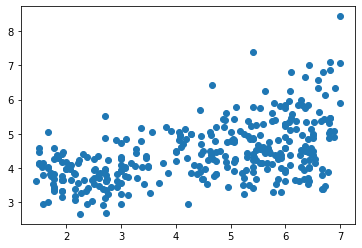

In [113]:
#visualizzo i risultati del test set
plt.scatter(test_scores, test_predictions_embeddings)

In [114]:
for metric in stampa_metriche(test_scores, test_predictions_embeddings):
    print(metric)

Correlazione di Spearman = 0.5071,p-value = 7.011513682084732e-24
Correlazione di Pearson = 0.5223 p-value = 1.7971668474245998e-25
MAE = 1.2132838482382846
MSE = 2.0837230480163886
RMSE = 1.4435106677875258
R2 = 0.27251536998687387


## Divisione dei WE per PoS

In [115]:
import copy
#faccio una copia delle frasi+pos per andare a modificarle 
NV_train_sentences = copy.deepcopy(train_sentences)
NV_test_sentences = copy.deepcopy(test_sentences)

In [116]:
NV_test_sentences[:10];

In [117]:
def split_piene_funz(dati):
    frasi_piene = []
    frasi_funz = []
    for fr in dati:
        nuova_frase_piena = []
        nuova_frase_funz = []
        for parola in fr:            
            if parola['pos'] in ['NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN']:
                nuova_frase_piena.append(parola)
            else:
                nuova_frase_funz.append(parola)
           
        frasi_piene.append(nuova_frase_piena)
        frasi_funz.append(nuova_frase_funz)
    return frasi_piene, frasi_funz

In [118]:
train_piene, train_funzionali = split_piene_funz(NV_train_sentences)
test_piene, test_funzionali = split_piene_funz(NV_test_sentences)

In [119]:
print(len(train_piene))
print(train_piene[0])

1339
[{'word': 'invitati', 'pos': 'NOUN', 'lemma': 'invitare'}, {'word': 'ritardo', 'pos': 'NOUN', 'lemma': 'ritardo'}, {'word': 'avvertiva', 'pos': 'VERB', 'lemma': 'avvertire'}, {'word': 'sempre', 'pos': 'ADV', 'lemma': 'sempre'}, {'word': 'ristorante', 'pos': 'NOUN', 'lemma': 'ristorante'}]


In [120]:
#elimino le parole piene o le parole funzionali dal train per fare delle analisi più specifiche
print(len(test_piene))
print(test_funzionali[0])

344
[{'word': 'senza', 'pos': 'ADP', 'lemma': 'senza'}, {'word': 'lui', 'pos': 'PRON', 'lemma': 'lui'}, {'word': 'la', 'pos': 'DET', 'lemma': 'il'}, {'word': 'alla', 'pos': 'ADP', 'lemma': 'a'}, {'word': '.', 'pos': 'PUNCT', 'lemma': '.'}]


In [133]:
#per parole funzionali usare questo
NV_train_sentences = train_funzionali
NV_test_sentences = test_funzionali

In [127]:
#per parole piene usare questo
NV_train_sentences = train_piene
NV_test_sentences = test_piene

In [134]:
#funzioni di gestione degli embeddings (come sopra)

def compute_embeddings_mean(user_embeddings):
    sum_array = np.sum(user_embeddings, axis=0)
    mean_array = np.divide(sum_array, len(user_embeddings))
    return mean_array

def compute_all_embeddings_mean(sentence_tokens):
    sentence_embeddings = []
    
    for token in sentence_tokens:
        word = token['word']
        if word in embeddings:
            sentence_embeddings.append(embeddings[word])
    
    if len(sentence_embeddings) == 0:
        sentence_embeddings = np.zeros(129)
    else:
        sentence_embeddings = compute_embeddings_mean(sentence_embeddings)
    return sentence_embeddings

def extract_embedding_features(dataset):
    dataset_features = []
    for sentence in dataset:
        sentence_embeddings = compute_all_embeddings_mean(sentence)
        dataset_features.append(sentence_embeddings)
    return dataset_features

In [135]:
train_NV_features_embeddings = extract_embedding_features(NV_train_sentences)

In [136]:
#normalizzazione embeddings 
scaler_embeddings = MinMaxScaler()
X_NVA_train_embeddings = scaler_embeddings.fit_transform(train_NV_features_embeddings)

In [137]:
X_NVA_train_embeddings.shape

(1339, 129)

In [138]:
#stampo i risultati delle 5 epoche di cross-validation e il risultato finale
do_5fcv(X_NVA_train_embeddings, train_scores)


R2 fold 1: 0.35334990507641206 - Baseline: -3.9829320552797753e-07
R2 fold 2: 0.2867822041107302 - Baseline: -0.0001651885378686213
R2 fold 3: 0.3129001263614438 - Baseline: -0.005663532786817527
R2 fold 4: 0.3391640558041754 - Baseline: -0.0006676591670384813
R2 fold 5: 0.33466860205969495 - Baseline: -0.00825695720269115
R2 tra gold e predizioni totali: 0.3267897277635319


### Test su parole funzionali

In [139]:
#estraggo le features del test set
test_NVA_features_embeddings = extract_embedding_features(NV_test_sentences)
X_NVA_test_embeddings = scaler_embeddings.fit_transform(test_NVA_features_embeddings)

In [140]:
#effettuo fit sul training set e predict sul test
svr_embeddings = LinearSVR(C=0.1, epsilon=0.5, loss='squared_epsilon_insensitive', dual=True, max_iter=10000)
svr_embeddings.fit(X_NVA_train_embeddings, train_scores)
test_predictions_embeddings = svr_embeddings.predict(X_NVA_test_embeddings)

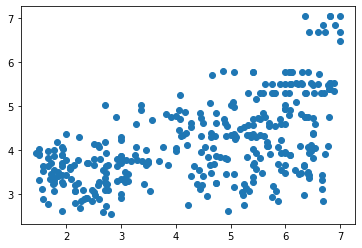

In [141]:
plt.scatter(test_scores, test_predictions_embeddings)

In [142]:
#calcolo le metriche di valutazione sul test set
for metric in stampa_metriche(test_scores, test_predictions_embeddings):
    print(metric)

Correlazione di Spearman = 0.5391,p-value = 2.479496533788817e-27
Correlazione di Pearson = 0.5561 p-value = 2.585065030255467e-29
MAE = 1.191332094174883
MSE = 2.064857527692534
RMSE = 1.4369612130090825
R2 = 0.2791018384169609
